# Building an inhibition-stabilised network 

Ta-Chu Kao and Guillaume Hennequin </center>

### Introduction 

In this short tutorial, we build an inhibition-stabilised network (ISN), 
using a slightly modified algorithm from the one  previously described in 
[Hennequin et al., 2014](https://www.sciencedirect.com/science/article/pii/S0896627314003602).

### Network paramters and initialisation

We have a total of $n$ neurons, $n_e$ of which are excitatory and the other $n_i$ are inhibitory.
The network connectivity matrix $W$ can be written in block-matrix form as:
$$\begin{bmatrix}
W_{EE} & W_{EI} \\
W_{IE} & W_{II}
\end{bmatrix},$$
where $W_{EE}$ are the $E$ to $E$ connections, $W_{EI}$ are the $I$ to $E$ connections and so on.

We initialise the network as follows: 
1. the density of excitatry connections is $p$, i.e. the probability of neuron $i$ projecting to neuron $j$ is $0 \leq p \leq 1$.
2. the excitatory weights are drawn a lognormal distribution with mean $\log(w_0)$ and variance 1. 
3. the inhibitory synapses are drawn from a uniform distribution between -1 and 0 


### Stability optimization

During optimization, we optimise only the inhibitory weights to stabilise the system.
We do so by minimising the smoothed spectral absicssa using gradient descent.
The method is described in detaail in 
([Hennequin et al., 2014](https://www.sciencedirect.com/science/article/pii/S0896627314003602) and
[Vanbiervliet, 2007](https://epubs.siam.org/doi/abs/10.1137/070704034?mobileUi=0)).

The gradient of the smoothed spectral abscissa with respect to the connectivity matrix $W$ is given by

$$\frac{\partial \alpha_\epsilon(W)}{\partial W} = \frac{QP}{\text{tr}(QP)},$$

where $Q$ and $P$ and the observability and controllability gramian of the system respectively.

Below, we use an adapative learning rate to speed up the optimization. 


### Normalising inhibitory weights

We normalise the inhibitory after each optimization step to maintain the DC mode of the system (the function 
`normalise` below does just that).
Here, the DC mode eigenvalue is set to $-10$ by default. 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
# useful functions in lib.py
from lib import spectral_abscissa, Gramians 
from plotlib import plot_eig, load_plot_setting
load_plot_setting()

### Network and optimization parameters

In [9]:
n_e = 160 # number of excitatory neurons
n_i = 40  # number of inhibitory neurons
n = n_e + n_i  # number of neurons
p = 0.2 # excitatory connection density
radius = 2. # spectral radius
w0 = radius / np.sqrt(p * (1-p) * n) # excitatory synaptic strength 

# useful slicing functions to extract the relevant blocks of the connectivity matrix
e = slice(0,None),slice(0,n_e)
i = slice(0,None),slice(n_e,None)
ee = slice(0,n_e), slice(0,n_e)
ei = slice(0,n_e), slice(n_e,None)
ie = slice(n_e,None), slice(0,n_e)
ii = slice(n_e,None), slice(n_e,None)

### Normalising funciton

In [10]:
dc_eval = -10 # eigenvalue of DC mode
def normalise(W):
    W[i] = np.minimum(0, W[i])
    z = (dc_eval - np.sum(W, axis=1).reshape(-1,1)) / n_i
    W[i] = np.minimum(0, z + W[i])
    W = W - np.diag(np.diag(W))
    return W

### Initialising the connectivity matrix

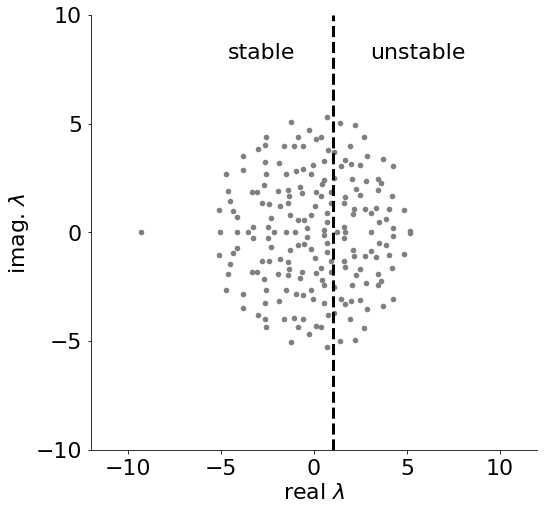

In [11]:
%matplotlib inline
def initialise():
    # initialise connectivity matrix with the right density
    W = np.random.lognormal(np.log(w0),1,size=[n,n])
    #build adjacency matrix of connections
    adjacency = np.random.uniform(0,1,size=[n,n_e])
    adjacency[adjacency>=p] = 2
    adjacency[adjacency<p] = 1
    adjacency[adjacency>1] = 0
    W[e] = W[e] * adjacency # remove silence percent of the synapses
    W[i] = -np.random.uniform(0,1,size=[n,n_i])
    W = W - np.diag(np.diag(W)) # remove self connections 
    W = normalise(W)
    return W 

W = initialise()
W_evals, _ = np.linalg.eig(W)

plot_eig(W_evals)

## Stability optimization

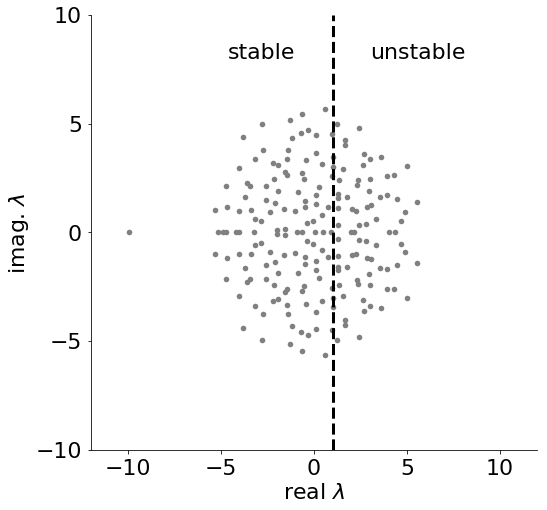

step   0 | spectral abscissa  5.650501 | shift: 6.780601 | learning rate: 1.000000 


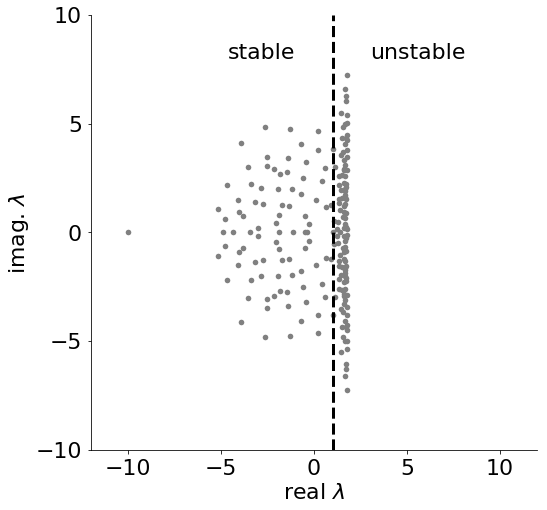

step 300 | spectral abscissa  1.799298 | shift: 2.159158 | learning rate: 1.661078 


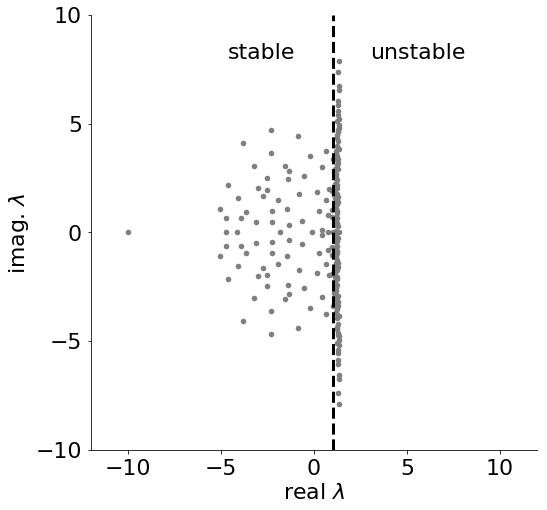

step 600 | spectral abscissa  1.370316 | shift: 1.644379 | learning rate: 1.138093 


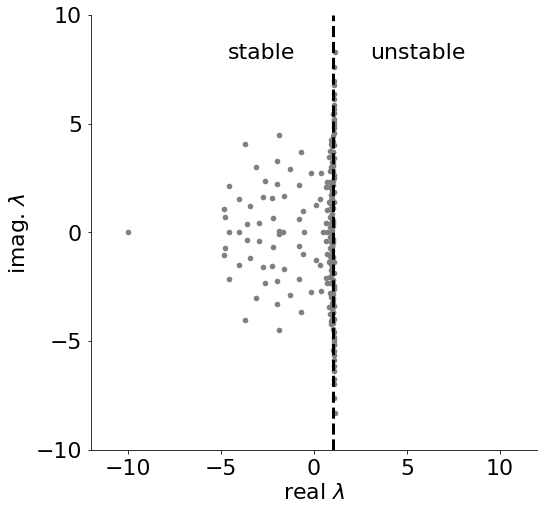

step 900 | spectral abscissa  1.124662 | shift: 1.349595 | learning rate: 1.232392 


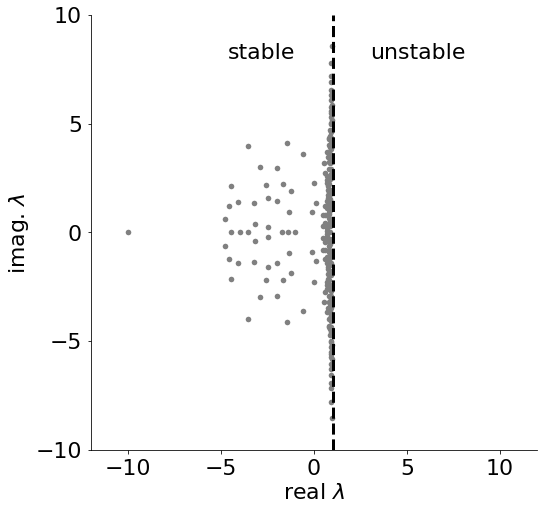

step 1200 | spectral abscissa  0.959369 | shift: 1.151243 | learning rate: 1.628348 
FINAL spectral abscissa  0.899837


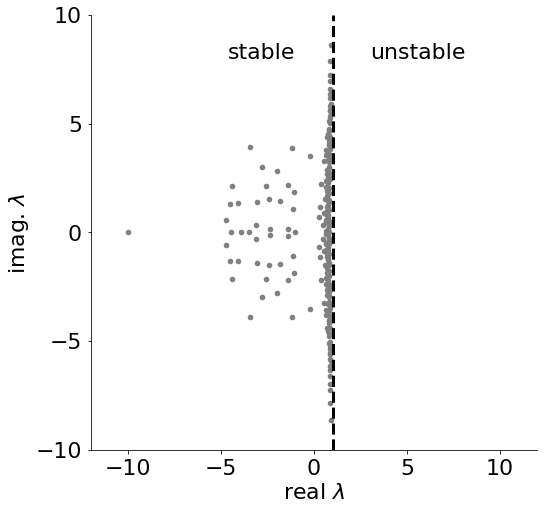

In [12]:
%matplotlib inline 
# initialise our matrix
W = initialise()
# optimisation parameters
n_iter = 5000 # number of training steps
threshold = 0.9 # stop optimization when spectral abscissa lower than threshold 
eta = 1  # initial learning rate
# optimisation flags
print_every = 300
plot_every = 300 
plt.ion()
# start stability optimization (takes about 1000 iterations)
for step in range(n_iter):
    s = spectral_abscissa(W) 
    if s < threshold: 
        print("FINAL spectral abscissa  %f" % s)
        W_evals, _ = np.linalg.eig(W)
        plot_eig(W_evals)
        break
    # adaptive learning rate
    eta = min(max(0.5 * eta if s > s_ else 1.01 * eta,1),8) if step > 0 else 1
    s_ = s # copy of spectral abscissa in this iteration for updating of learning rate in next iteration
    shift = max(1, 1.2*s) 
    A = W - shift * np.eye(n)
    Q = Gramians.obsv(A) # observability gramian
    P = Gramians.ctrl(A) # controllability gramian
    QP = Q.dot(P)
    dW = QP / np.trace(QP) # gradient of smoothed spectral abscissa with respect to W
    W[i]  = W[i] - eta * dW[i]
    W = normalise(W) # normalise W after each iteration
    if (step % plot_every) == 0:
        W_evals, _ = np.linalg.eig(W)
        plot_eig(W_evals)
    if step % print_every == 0:
        print("step %3i | spectral abscissa  %f | shift: %8f | learning rate: %f " % ((step,s,shift, eta)))

In [14]:
# Now let's save our inhibition stabilised network 
isn_name = "isn.txt"
np.savetxt(isn_name,W)